In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [2]:
config = {
    'n_epochs': 400,
    'batch_size': 512,
    'optimizer': 'Adam',       
    'optim_hparas': {              
        'lr': 0.001,
        # 'weight_decay': 0.0001
        # 'momentum': 0.9         
    },
    'early_stop': 20,        
    'save_path': 'models/model.pth', 
    'D': 50,
    'alpha': 0.05,
    # 'step_size'
}

init_Seed()
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models


data_train = '../data/ML100K/ML100K_copy1_train.txt'
data_test = '../data/ML100K/ML100K_copy1_test.txt'
n_users = 1000
n_items = 2000
n_factors = 50

tr_set = prep_dataloader(data_train, 'train', config['batch_size'])
dv_set = prep_dataloader(data_test, 'dev', config['batch_size'])
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

GPU ready!
Max user: 943
Max item: 1682
Finished reading the train set of MoviesLen Dataset (60000 samples found, each dim = 2)
Max user: 943
Max item: 1679
Finished reading the dev set of MoviesLen Dataset (20000 samples found, each dim = 2)


In [3]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for X, y in dv_set:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = model(X[:, 0], X[:, 1])
            mse_loss = model.cal_loss(pred, y)
        total_loss += mse_loss.detach().cpu().item() * len(y)

    rmse = np.sqrt(total_loss / len(dv_set.dataset))
    return rmse

In [4]:
def train(tr_set, dv_set, model, optimizer, scheduler=None, device='cpu', n_epochs=100, early_stop=5):
    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0

    animator = d2l.Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0.7, 1],
                        legend=['train loss', 'test loss'],
                        figsize=(6, 6))
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])
            mse_loss = model.cal_loss(y_hat, y) + model.regularizer(X[:, 0], X[:, 1])
            mse_loss.backward()
            optimizer.step()
            # loss_record['train'].append(mse_loss.detach().cpu().item())
            # print("train_loss: {:.4f}".format(np.sqrt(mse_loss.detach().cpu().item())))

        if scheduler:
            scheduler.step()
        
        epoch += 1

        train_rmse =  dev(tr_set, model, device)
        dev_rmse = dev(dv_set, model, device)

        animator.add(epoch, (train_rmse, dev_rmse))
        # print("epoch = {:4d} RMSE: {:.4f}".format(epoch, dev_rmse))

        if dev_rmse < min_mse:
            min_mse = dev_rmse
            early_stop_cnt = 0
            # print("Saving model (epoch = {:4d}  RMSE = {:.4f} )".format(epoch, dev_rmse))
            # torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        

        if early_stop_cnt > early_stop:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

In [5]:
class MF(nn.Module):
    def __init__(self, n_users=6050, m_items=4050, n_factors=20, alpha=0.05):

        super(MF, self).__init__()
        self.alpha = alpha
        self.U = torch.nn.Parameter(torch.rand(n_users, n_factors, requires_grad=True))
        self.V = torch.nn.Parameter(torch.rand(m_items, n_factors, requires_grad=True))

        self.U.data.uniform_(-0.005, 0.005)
        self.V.data.uniform_(-0.005, 0.005)
        
        self.criterion = nn.MSELoss(reduction='mean')
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, user, item):
        # return torch.einsum('ij, ij -> i', [self.U[user], self.P[item] @ self.Q])
        return torch.einsum('ij, ij -> i', [self.U[user], self.V[item]])
#         return torch.einsum('ij, ij -> i', [self.dropout(self.U[user]), self.dropout(self.V[item])])

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

    def regularizer(self, user, item):
        return self.alpha * (self.U[user].norm() ** 2 + self.V[item].norm() ** 2) / len(user)

Finish training after 95 epochs


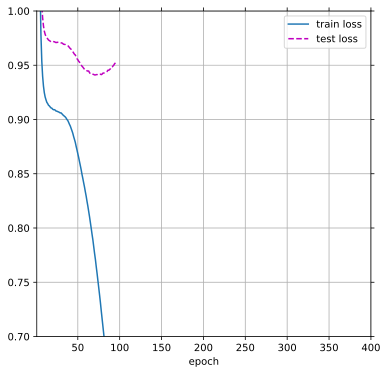

In [6]:
model = MF(n_users, n_items, n_factors, config['alpha']).to(device) 

optimizer = getattr(torch.optim, config['optimizer'])(
    model.parameters(), **config['optim_hparas'])

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])
scheduler = None

model_loss, model_loss_record = train(tr_set, dv_set, model, optimizer, scheduler, device, config['n_epochs'], config['early_stop'])

In [7]:
model_loss

0.9409955636020231

In [8]:
# print(np.sqrt(model_loss))

# del model
# model = MF(n_users, n_items, n_factors).to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# print(dev(dv_set, model, device))